Available numeric columns: ['MA', 'bedrooms']


<ipython-input-2-5c0d29758551>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['MA_shifted'] = df['MA'].shift(1).fillna(method='bfill')  # Create a lagged version


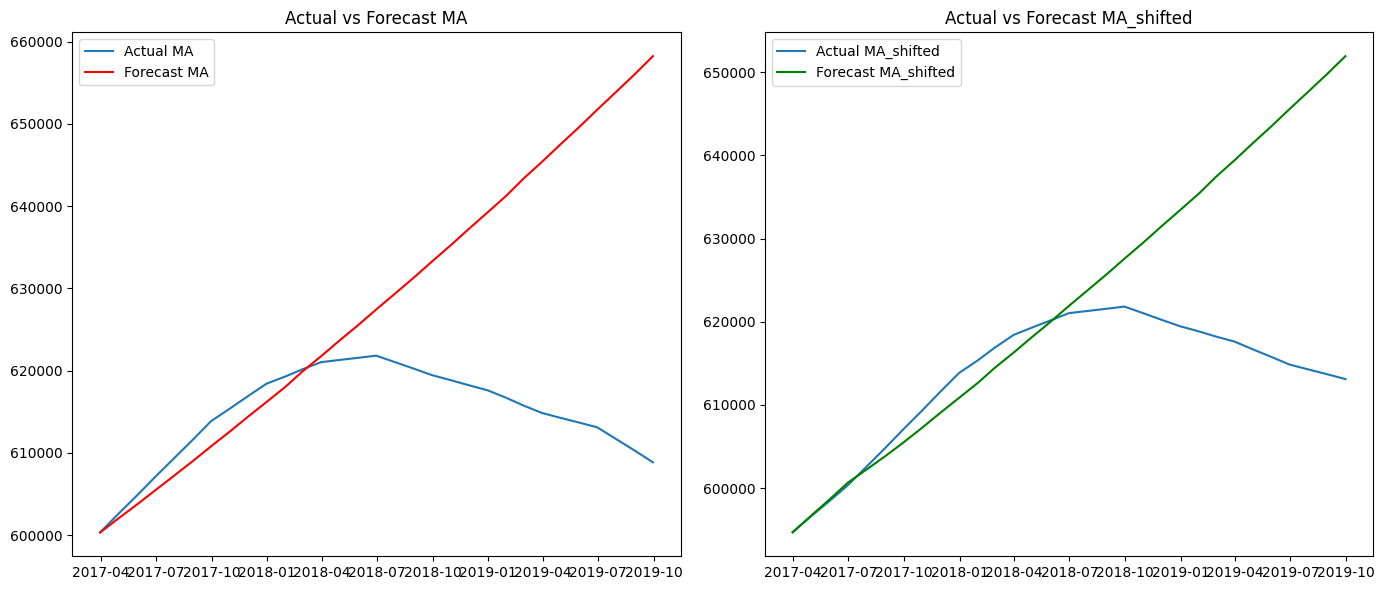

MA RMSE: 21306.17
MA_shifted RMSE: 15928.27


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

# Load dataset
file_path = "/content/ma_lga_12345.csv"
df = pd.read_csv(file_path)

# Convert 'saledate' to datetime
df['saledate'] = pd.to_datetime(df['saledate'], format="%d/%m/%Y")
df.set_index('saledate', inplace=True)

# Check available numeric columns
print("Available numeric columns:", df.select_dtypes(include='number').columns.tolist())

# Use 'MA' and create a synthetic second variable
df['MA_shifted'] = df['MA'].shift(1).fillna(method='bfill')  # Create a lagged version

# Resample monthly and interpolate
data = df[['MA', 'MA_shifted']].resample('ME').mean().interpolate()

# Train-test split
n_obs = int(len(data) * 0.8)
train, test = data[:n_obs], data[n_obs:]

# Fit the VAR model
model = VAR(train)
model_fitted = model.fit(maxlags=15, ic='aic')

# Forecast
forecast_input = train.values[-model_fitted.k_ar:]
forecast = model_fitted.forecast(y=forecast_input, steps=len(test))

# Create forecast DataFrame
forecast_df = pd.DataFrame(forecast, index=test.index, columns=['MA_forecast', 'MA_shifted_forecast'])

# Plot forecasts
plt.figure(figsize=(14, 6))

# MA
plt.subplot(1, 2, 1)
plt.plot(test.index, test['MA'], label='Actual MA')
plt.plot(test.index, forecast_df['MA_forecast'], label='Forecast MA', color='red')
plt.title('Actual vs Forecast MA')
plt.legend()

# MA_shifted
plt.subplot(1, 2, 2)
plt.plot(test.index, test['MA_shifted'], label='Actual MA_shifted')
plt.plot(test.index, forecast_df['MA_shifted_forecast'], label='Forecast MA_shifted', color='green')
plt.title('Actual vs Forecast MA_shifted')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
ma_rmse = np.sqrt(mean_squared_error(test['MA'], forecast_df['MA_forecast']))
ma_shifted_rmse = np.sqrt(mean_squared_error(test['MA_shifted'], forecast_df['MA_shifted_forecast']))

print(f"MA RMSE: {ma_rmse:.2f}")
print(f"MA_shifted RMSE: {ma_shifted_rmse:.2f}")
